<a href="https://colab.research.google.com/github/nikanor97/Kaggle-LandmarkRecognition2019/blob/master/LandmarkRecognition2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorboardcolab import *
tbc=TensorBoardColab()

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://bd753d11.ngrok.io


In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
setup_google_colab.setup_week3()
# setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2019-05-03 22:22:06--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-05-03 22:22:06 (93.1 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat
**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.ta

In [0]:
#!rm -f images_033_224_pool.tar

# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/inceptionv3.png?raw=1" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/flowers.jpg?raw=1" style="width:70%">

# Import stuff

In [0]:
#import sys
#sys.path.append("..")
#import grading
#import download_utils

In [0]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!

In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import keras_utils
from keras_utils import reset_tf_session

import itertools
import pandas as pd
from sklearn.utils import shuffle

Using TensorFlow backend.


1.13.1
2.0.6


# Prepare images for model

In [0]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
#IMG_SIZE = 250
IMG_SIZE = 224

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
  
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    #img = image_center_crop(img)  # take squared center crop
    #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img
  
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(224, 224, 3)
(224, 224, 3)


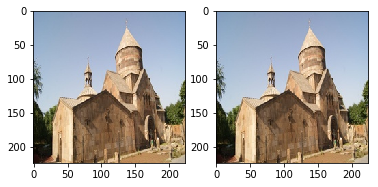

In [0]:
# test cropping #actually no cropping anymore
#raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")
raw_bytes = read_raw_from_tar("images_000_224_pool.tar", "./000a0aee5e90cbaf.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(img)

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.subplot(1,2,2)
plt.imshow(img)

# Prepare for training

In [0]:
# read all filenames and labels for them

# read filenames directly from tar
#def get_all_filenames(tar_fn):
#    with tarfile.open(tar_fn) as f:
#        return [m.name for m in f.getmembers() if m.isfile()]
def get_all_filenames_labels(dataset_numbers):
  images_id = list()
  images_labels = list()
  tar_numbers = list()
  for dataset_number in dataset_numbers:
    images_data = pd.read_csv('images_' + dataset_number + '_labels.csv')
    images_id = sum([images_id, list(images_data['id'])],[])
    images_labels = sum([images_labels, list(images_data['landmark_id'])],[])
    for i in range(len(images_data['id'])):
      tar_numbers.append(dataset_number)
  return images_id, images_labels, tar_numbers

def get_all_filenames_224_labels(dataset_numbers):
  images_id = list()
  images_labels = list()
  tar_numbers = list()
  for dataset_number in dataset_numbers:
    images_data = pd.read_csv('images_' + dataset_number + '_labels.csv')
    images_id = sum([images_id, list(images_data['id'])],[])
    images_labels = sum([images_labels, list(images_data['landmark_id'])],[])
    for i in range(len(images_data['id'])):
      tar_numbers.append(dataset_number + '_224')
  return images_id, images_labels, tar_numbers


dataset_numbers = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', 
                   '010', '011', '012', '013', '014', '015', '016', '017', '018', '019',
                   '020', '021', '022', '023', '024', '025', '026', '027', '028', '029',
                   '030', '031', '032', '033', '034', '035', '036', '037', '038', '039',
                   '040', '041', '042', '043', '044', '045', '046', '047', '048', '049',
                   '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', 
                   '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', 
                   '070', '071', '072', '073', '074', '075', '076', '077', '078', '079',
                   '080', '081', '082', '083', '084', '085', '086', '087', '088', '089',
                   '090', '091', '092', '093', '094', '095', '096', '097', '098', '099']
all_files, all_labels, all_tar_numbers = get_all_filenames_224_labels(dataset_numbers)


#dataset_numbers = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
                   #'010', '011', '012', '013', '014', '015', '016', '017', '018', '019',
                   #'020', '021', '022', '023', '024', '025', '026', '027', '028', '029',
                   #'030', '031', '032', '033', '034', '035', '036', '037', '038', '039',
                   #'040', '041', '042', '043', '044', '045', '046', '047', '048', '049',]
                   #'050', '051', '052', '053', '054', '055', '056', '057', '058', '059', 
                   #'060', '061', '062', '063', '064', '065', '066', '067', '068', '069', 
                   #'070', '071', '072', '073', '074', '075', '076', '077', '078', '079',
                   #'080', '081', '082', '083', '084', '085', '086', '087', '088', '089',
                   #'090', '091', '092', '093', '094', '095', '096', '097', '098', '099']
#all_files, all_labels, all_tar_numbers = get_all_filenames_labels(dataset_numbers)

print(len(all_files))
print(len(all_labels))
print(len(all_tar_numbers))

# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)


826600
826600
826600
150354


In [0]:
train_data = pd.DataFrame({'id':all_files, 'landmark_id': all_labels, 'tar_number': all_tar_numbers})
temp = pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp.tail(8)

,landmark_id,count
150346,14271,1
150347,19325,1
150348,52969,1
150349,94806,1
150350,65263,1
150351,188386,1
150352,84561,1
150353,98156,1


In [0]:
temp.head()

,landmark_id,count
0,138982,2025
1,62798,873
2,176528,693
3,177870,602
4,126637,524


In [0]:
def showImages(landmark_id):
  train_data_inclass = train_data.loc[train_data['landmark_id'] == landmark_id]
  train_data_inclass = shuffle(train_data_inclass)
  train_data_inclass = train_data_inclass.reset_index(drop=True)
  print('count: ', temp.loc[temp['landmark_id'] == landmark_id]['count'])
  print(train_data_inclass.head())

  raw_bytes = list()
  for i in range(min(12, len(train_data_inclass['id']))):
    tar_number = train_data_inclass['tar_number'][i]
    image_id = train_data_inclass['id'][i]
    try:
      raw_bytes.append(read_raw_from_tar("images_"+tar_number+"_pool.tar", "./"+image_id+".jpg"))
    except:
      print('image "'+image_id+'" can not be found')
      continue

  img = list()
  for i in range(len(raw_bytes)):
    img.append(decode_image_from_raw_bytes(raw_bytes[i]))

  f = plt.figure(figsize=(20,15))

  for i in range(min(len(img), 12)):
    ax = f.add_subplot(3, 4, i+1)
    ax.imshow(img[i])
  

count:  4    524
Name: count, dtype: int64
                 id  landmark_id tar_number
0  1ace83466a971f3a       126637    052_224
1  20b0c23947fd13b7       126637    063_224
2  291ef8fc6dad86a6       126637    080_224
3  155af67d790d4a73       126637    041_224
4  1ba04d0f5661bd84       126637    053_224


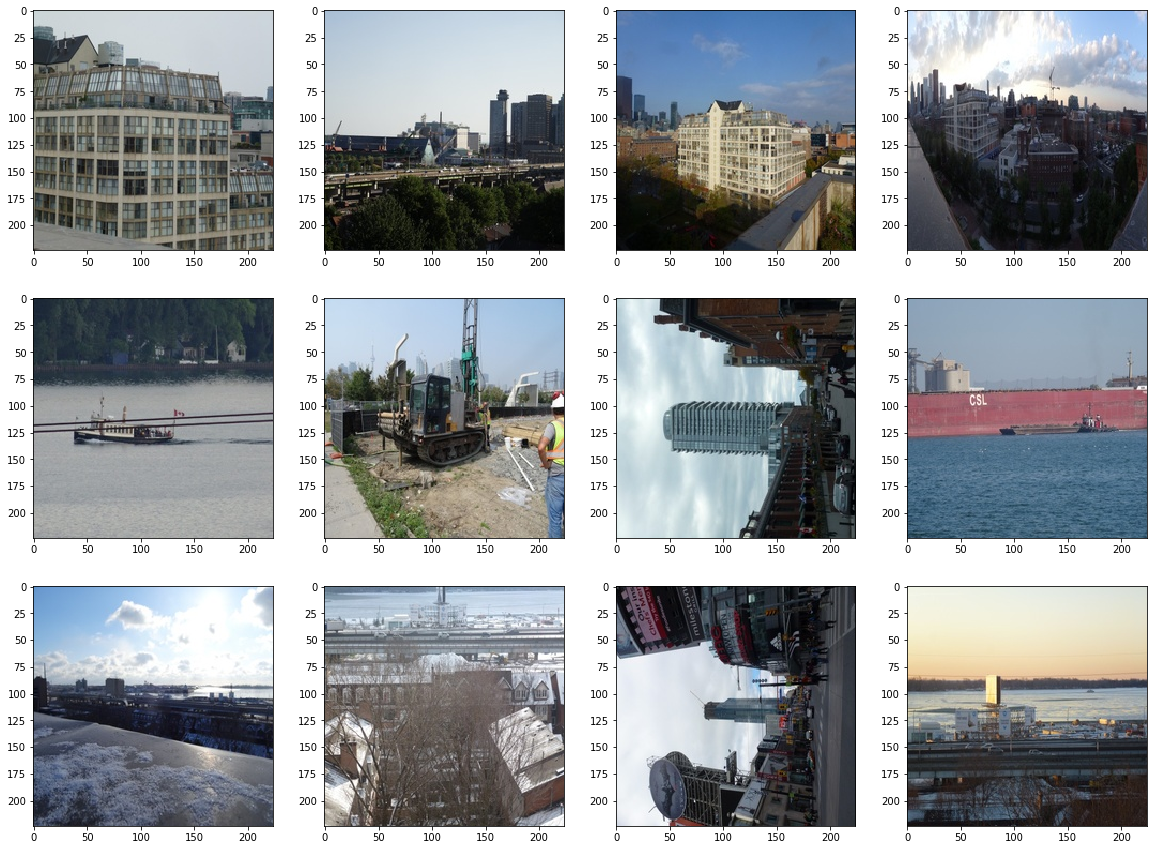

In [0]:
showImages(126637)

In [0]:
MIN_LANDMARK_COUNT = 10 # если картинок с лейблом меньше этого кол-ва то все они в топку

def remove_small_classes(temp, all_files, all_labels, all_tar_numbers):
  bad_landmark_ids = set()

  for i in range(len(temp['count'])):
    if temp['count'][i] < MIN_LANDMARK_COUNT:
      landmark_id = temp['landmark_id'][i]
      bad_landmark_ids.add(landmark_id)

  bad_file_idxs = list()    
  for idx in range(len(all_labels)):
    if all_labels[idx] in bad_landmark_ids:
      bad_file_idxs.append(idx)

  bad_file_idxs.reverse()

  for i in bad_file_idxs:
    del all_files[i]
    del all_labels[i]
    del all_tar_numbers[i]
    
remove_small_classes(temp, all_files, all_labels, all_tar_numbers)

In [0]:
train_data = pd.DataFrame({'id':all_files, 'landmark_id': all_labels})
temp = pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp.tail(8)

,landmark_id,count
20649,172800,10
20650,184187,10
20651,168667,10
20652,124702,10
20653,18864,10
20654,140340,10
20655,138291,10
20656,171426,10


In [0]:
print(len(all_files))
print(len(all_labels))
print(len(all_tar_numbers))

# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)


448572
448572
448572
20657


In [0]:
# изменим landmark_id в соответствие с изменившимся кол-вом классов
landmark_id2new = dict()
landmark_id2old = dict()
for i in range(len(temp['landmark_id'])):
  landmark_id2new[temp['landmark_id'][i]] = i
  landmark_id2old[i] = temp['landmark_id'][i]
  
for i in range(len(all_labels)):
  all_labels[i] = landmark_id2new[all_labels[i]]

In [0]:
train_data = pd.DataFrame({'id':all_files, 'landmark_id': all_labels, 'tar_number' : all_tar_numbers})
train_data.head()

,id,landmark_id,tar_number
0,0047383356212b17,808,000_224
1,00530cb44c77ae7c,2642,000_224
2,00576c22c241def1,7299,000_224
3,00422d7e9c9614ae,10266,000_224
4,001a18f2989aa66c,771,000_224


In [0]:
# split into train/test
#tr_files, te_files, tr_labels, te_labels = \
#    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [0]:
# will yield raw image bytes from tar with corresponding label
#def raw_generator_with_label_from_tar(tar_fn, files, labels):
def raw_generator_with_label_from_tar(files, labels):
  label_by_filename = dict(zip(files, labels))
  for dataset_number in dataset_numbers:
    with tarfile.open('images_'+dataset_number+'_224_pool.tar') as f:
      while True:
        try:
          m = f.next()
        except StopIteration as e:
          print("An error in 'raw_generator_with_label_from_tar': ", e)
          break
        if m is None:
          break
        if m.name[-20:-4] in label_by_filename:
          yield f.extractfile(m).read(), label_by_filename[m.name[-20:-4]]

In [0]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    batch = list()
    for item in items:
        batch.append(item)
        if len(batch) == batch_size:
            yield batch
            batch.clear()
    yield batch

In [0]:
def train_generator(files, labels):
  #print('hello')
  while True:  # so that Keras can loop through this as long as it wants
    for batch in batch_generator(raw_generator_with_label_from_tar(files, labels), BATCH_SIZE):
      #print(batch)
      # prepare batch images
      batch_imgs = []
      batch_targets = []
      for raw, label in batch:
        img = prepare_raw_bytes_for_model(raw)
        batch_imgs.append(img)
        batch_targets.append(label)
      # stack images into 4D tensor [batch_size, img_size, img_size, 3]
      batch_imgs = np.stack(batch_imgs, axis=0)
      # convert targets into 2D tensor [batch_size, num_classes]
      batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
      yield batch_imgs, batch_targets

(32, 224, 224, 3) (32, 20657)


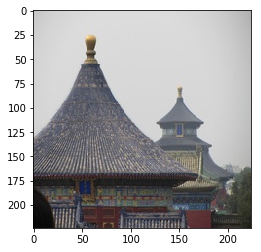

In [0]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [0]:
# remember to clear session if you start building graph from scratch!
s = reset_tf_session()
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [0]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    #model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
    #                                      weights='imagenet' if use_imagenet else None)
    model = keras.applications.ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [0]:
model = inception()

In [0]:
#model.summary()

In [0]:
# how many layers our model has
print(len(model.layers))

177


In [0]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [0]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    #optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    optimizer=keras.optimizers.adamax(lr=1e-3),  # we can take big lr here because we fixed first layers
    #optimizer=keras.optimizers.adamax(lr=1e-4),  # we can take big lr here because we fixed first layers
    #optimizer=keras.optimizers.adamax(lr=0.0005),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [0]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'landmarks.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 10
# model = load_model(model_filename.format(last_finished_epoch))

In [0]:
#from keras.models import load_model
#model.load_weights('model_resnet50_40epochs.hdf5')

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [0]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
history = model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=5 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[keras_utils.TqdmProgressCallback(), keras_utils.ModelSaveCallback(model_filename)],
    #callbacks=[keras_utils.TqdmProgressCallback(),
    #           keras.callbacks.TensorBoard(log_dir='./logs')],
    verbose=0,
    #initial_epoch=last_finished_epoch or 0
)

#https://keras.io/callbacks/
#keras.callbacks.LearningRateScheduler(schedule, verbose=0)
#keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
#keras.callbacks.CSVLogger(filename, separator=',', append=False)


Instructions for updating:
Use tf.cast instead.

Epoch 1/40
**************************************************
loss: 9.7614; acc: 0.0069; val_loss: 9.5905; val_acc: 0.0076
Model saved in landmarks.000.hdf5

Epoch 2/40
**************************************************
loss: 9.5454; acc: 0.0092; val_loss: 9.3453; val_acc: 0.0121
Model saved in landmarks.001.hdf5

Epoch 3/40
**************************************************
loss: 9.3474; acc: 0.0117; val_loss: 9.1315; val_acc: 0.0129
Model saved in landmarks.002.hdf5

Epoch 4/40
**************************************************
loss: 9.1535; acc: 0.0145; val_loss: 8.8897; val_acc: 0.0154
Model saved in landmarks.003.hdf5

Epoch 5/40
**************************************************
loss: 8.9651; acc: 0.0153; val_loss: 8.7220; val_acc: 0.0148
Model saved in landmarks.004.hdf5

Epoch 6/40
**************************************************
loss: 8.8245; acc: 0.0155; val_loss: 8.5138; val_acc: 0.0201
Model saved in landmarks.005.hdf5

Epo

In [0]:
#model.save('my_model_4.h5')

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored

In [0]:
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
print(test_accuracy)

0.14422013274336284


In [0]:
test_accuracy = model.evaluate_generator(
    train_generator(all_files, all_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
print(test_accuracy)

0.38046183628318586


In [0]:
probabilities = list()
handled_ids = list()
with open('test_answers.csv', 'a') as csv_file:
  pd.DataFrame(dict(), columns=['id', 'landmarks']).to_csv(csv_file, index = False)
for testset_number in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 
                       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 
                       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', 
                       '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', 
                       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', 
                       '51', '52', '53', '54', '55', '56', '57']:
  print('testset_number: ', testset_number)
  test_dataset = list()
  test_ids = list()
  with tarfile.open('test_data_224_' + testset_number + '.tar') as f:
    while True:
      m = f.next()
      if m is None:
        break
      file_obj = f.extractfile(m)
      if file_obj is not None: 
        test_dataset.append(file_obj.read())
        test_ids.append(m.name[-20:-4])
        handled_ids.append(m.name[-20:-4])
        
  for i in range(len(test_dataset)):
    test_dataset[i] = prepare_raw_bytes_for_model(test_dataset[i])
  print('cycle done')
  test_dataset = np.stack(test_dataset, axis=0)
  print('stacking done')

  test_probabilities = model.predict(test_dataset)
  print('test_probabilities ready')
  
  test_predictions = list()
  for i in range(len(test_probabilities)):
    label = landmark_id2old[np.argmax(test_probabilities[i])]
    probability = np.max(test_probabilities[i]) * 100000 // 1 / 100000
    probabilities.append(probability)
    if probability < 0: # threshold for non-landmark mage. better not to set it
      test_predictions.append('')
    else:
      test_predictions.append(str(label) + ' ' + str(probability))
  print('test_predictions ready')
  
  with open('test_answers.csv', 'a') as csv_file:
    pd.DataFrame({'id' : test_ids, 'landmarks' : test_predictions}).to_csv(csv_file, header = False, index = False)
  print('csv ready')

testset_number:  01
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  02
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  03
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  04
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  05
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  06
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  07
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  08
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  09
cycle done
stacking done
test_probabilities ready
test_predictions ready
csv ready
testset_number:  10
cycle done
stacking done
test_probabilities ready
tes

(array([  34.,  282.,  865., 1593., 2489., 3201., 3813., 4147., 4312.,
        4435., 4413., 4245., 4310., 4049., 3946., 3630., 3597., 3305.,
        3186., 2915., 2737., 2552., 2425., 2286., 2163., 2044., 1856.,
        1814., 1668., 1634., 1489., 1421., 1326., 1204., 1171., 1114.,
        1047.,  981.,  965.,  883.,  850.,  803.,  765.,  714.,  706.,
         622.,  617.,  586.,  557.,  507.,  486.,  471.,  468.,  471.,
         447.,  373.,  394.,  393.,  346.,  334.,  312.,  305.,  328.,
         301.,  265.,  271.,  270.,  227.,  227.,  241.,  204.,  190.,
         184.,  185.,  167.,  163.,  167.,  158.,  141.,  159.,  136.,
         126.,  125.,  117.,  109.,  109.,   93.,  100.,  102.,   75.,
          89.,   73.,   80.,   76.,   70.,   52.,   61.,   57.,   54.,
          70.]),
 array([0.01871  , 0.0285186, 0.0383272, 0.0481358, 0.0579444, 0.067753 ,
        0.0775616, 0.0873702, 0.0971788, 0.1069874, 0.116796 , 0.1266046,
        0.1364132, 0.1462218, 0.1560304, 0.165839 , 0.

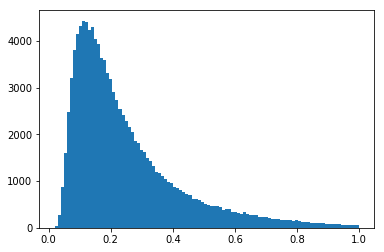

In [0]:
plt.hist(probabilities, bins=100)

In [0]:
with open('test.csv') as csv_file:
  initial_ids = pd.read_csv(csv_file)['id']

In [0]:
print(len(initial_ids))
print(len(handled_ids))
print(len(set(initial_ids) - set(handled_ids)))

117703
112696
5007


In [0]:
missed_ids = list(set(initial_ids) - set(handled_ids))

In [0]:
with open('test_answers.csv', 'a') as csv_file:
    pd.DataFrame({'id' : missed_ids, 'landmarks' : ['' for i in range(len(missed_ids))]}).to_csv(csv_file, header = False, index = False)

In [0]:
with open('test_answers - 3 submit.csv') as csv_file:
  tmp_df = pd.read_csv(csv_file)
tmp_df.head()

,id,landmarks
0,55c9a0fc70c068cf,83211 0.71569
1,764c8b5cfbfff70d,113300 0.56541
2,7ade02cae7d73467,125547 0.13829
3,2de3c8d4679c8506,159814 0.35472
4,5f176534332d702e,138247 0.20499


In [0]:
tmp_landmarks = list(tmp_df['landmarks'])
tmp_landmarks[:5]

['83211 0.71569',
 '113300 0.56541',
 '125547 0.13829',
 '159814 0.35472',
 '138247 0.20499']

In [0]:
type(tmp_landmarks[0])

str

In [0]:
import re

In [0]:
landmark = list()
for i in range(len(tmp_landmarks)):
  landmark.append(re.split(' ', str(tmp_landmarks[i]))[0])
print(landmark[:5])

['83211', '113300', '125547', '159814', '138247']


In [0]:
len(landmark)

117703

In [0]:
for i in range(len(landmark)):
  if landmark[i] == 'nan':
    landmark[i] = ''

In [0]:
landmark[-5]

''

In [0]:
for i in range(len(landmark[:-4955])):
  landmark[i] += ' 0.9'

In [0]:
print(landmark[:5])

['83211 0.9', '113300 0.9', '125547 0.9', '159814 0.9', '138247 0.9']


In [0]:
df = pd.DataFrame({'id':list(tmp_df['id']), 'landmarks': landmark})

In [0]:
df.head()

,id,landmarks
0,55c9a0fc70c068cf,83211 0.9
1,764c8b5cfbfff70d,113300 0.9
2,7ade02cae7d73467,125547 0.9
3,2de3c8d4679c8506,159814 0.9
4,5f176534332d702e,138247 0.9


In [0]:
with open('test_answers.csv', 'a') as csv_file:
    pd.DataFrame(df).to_csv(csv_file, index = False)

That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model